# Population Density & Venue Data Analysis of Yangon 

###### Applied Data Science : Capestone Project

## Introduction : Business Problem

**Yangon**, the commercial capital and the largest city of **Myanmar**, is a densely populated city. In this project, we will find out a suitable location for a __Café__ or a __bakery__. 

We will focus on the __population density__ of each neighborhood. We are also interested in areas with __shopping centers__ or __hotels__ nearby but without much __similar shops__ in the vicinity. 

With the datasets obtained, we will find out some suitable areas.

## Data

For our problem, these factors will be mainly focused : 
* Population Density of the neighborhood
* Distance from the nearest Hotel or Shopping Center
* Distance from similar shops
* Distance from a landmark 

The following data are needed for information extraction : 
* Population data and landmark data from **Wikipedia**
* **Json** file for neighborhood bordrer
* **Foursquare** for venue data

### Population Density

Using the exact population data of each township accoridng to the **2014 Census** and **annual population growth rate**, the estimated population density per squared kilometer is calculated.

The exact kind of data required couldn't be found so I had to make my own data frame in order to match the township names on the geojson file. 

(Something problematic is that the names of townships are represented differently on different websites as English can't be used to pronounced the exact Myanmar names for specific words)

So, the names of tonwhsips are first obtained from the **geojson file**.

In [1]:
import json

with open('ygn_townships.geojson') as json_data:
    ygn_data = json.load(json_data)
    
ygn = ygn_data['features']

ts =[]

for data in ygn:
    ts.append(data['properties']['Name'])
ts.sort()
print(ts)
len(ts)

['AHLON', 'BAHAN', 'BOTAHTAUNG', 'DAGON', 'DAGON SEIKKAN', 'DALA', 'DAWBON', 'EAST DAGON', 'HILEGU', 'HLAING', 'HLAINGTHAYA', 'HMAWBI', 'INSEIN', 'KAMARYUT', 'KYAUK TAN', 'KYAUKTADA', 'KYEEMYINDAING LEFT BANK', 'KYEEMYINDAING RIGHT BANK', 'LANMADAW', 'LATHA', 'MAYANGONE', 'MINGALARDON', 'MINGALARTAUNGNYUNT', 'NORTH DAGON', 'NORTH OKKALAPA', 'PABEDAN', 'PAZUNDAUNG', 'SANCHAUNG', 'SEIKGYIKANAUNGTO', 'SEIKKAN', 'SHWEPYITHA', 'SOUTH DAGON', 'SOUTH OKKALAPA', 'TARMWE', 'THAKETA', 'THANLYIN', 'THINGANGYUN', 'TWAN TAY', 'YANKIN']


39

Our custom dataframe contains the name of neighborhood(township), Coordinates, Population according to 2014 Census and Area in square kilometer.

In [2]:
import pandas as pd

In [3]:
df_ygn_ts = pd.read_csv('YangonTownships.csv')
df_ygn_ts.head()

Township   Latitude  Longitude  Population_2014_Census  Area_sqkm
0          BOTAHTAUNG  16.767500  96.151389                   40995       2.40
1       DAGON SEIKKAN  16.856667  96.282778                  167448      85.40
2              DAWBON  16.666667  96.183333                   75325       3.70
3          EAST DAGON  16.883333  96.283333                  165628      91.03
4  MINGALARTAUNGNYUNT  16.783333  96.166667                  132494       5.06

Then, the estimated population for 2020 is calculated from the annual population growth rate obtained from a website.

Finally, the population density is calculated.

In [4]:
#population growth rate
g16 = g17 = g18 = 2.06
g19 = 1.69
g20 = 1.68
rate = [g16,g17,g18,g19,g20]

def growth(num):
    grown = num
    for i in rate:
        grown += grown*(i/100)
    return (int(grown))

df_ygn_ts['Population_2020_Estimated'] = df_ygn_ts['Population_2014_Census'].apply(growth)

df_ygn_ts['Population_density/sqkm'] = df_ygn_ts['Population_2020_Estimated'] / df_ygn_ts['Area_sqkm']
df_ygn_ts = df_ygn_ts.astype({'Population_density/sqkm':int})
df_ygn_ts.head()

Township   Latitude  Longitude  Population_2014_Census  \
0          BOTAHTAUNG  16.767500  96.151389                   40995   
1       DAGON SEIKKAN  16.856667  96.282778                  167448   
2              DAWBON  16.666667  96.183333                   75325   
3          EAST DAGON  16.883333  96.283333                  165628   
4  MINGALARTAUNGNYUNT  16.783333  96.166667                  132494   

   Area_sqkm  Population_2020_Estimated  Population_density/sqkm  
0       2.40                      45062                    18775  
1      85.40                     184060                     2155  
2       3.70                      82797                    22377  
3      91.03                     182059                     1999  
4       5.06                     145638                    28782

Now, it's time to use the geojson file and visualize our cleaned data.

First, we will get the latitude and longitude of Yangon by using geocoder.

Then, using the above dataframe, we can generate a **choropleth map** of population density.

In [5]:
from geopy.geocoders import Nominatim
import numpy as np
import folium

address = 'Yangon,YGN'

geolocator = Nominatim(user_agent='explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

ygn_geo = r'ygn_townships.geojson'
ygn_map = folium.Map(location=[latitude,longitude], zoom_start = 11)

threshold_scale = np.linspace(df_ygn_ts['Population_density/sqkm'].min(),
                              df_ygn_ts['Population_density/sqkm'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1 

In [6]:
ygn_map.choropleth(geo_data = ygn_geo,
                   data = df_ygn_ts,
                   columns = ['Township','Population_density/sqkm'],
                   key_on = 'feature.properties.Name',
                   threshold_scale=threshold_scale,
                   fill_color = 'YlOrRd',
                   fill_opacity = 0.7,
                   line_opacity = 0.3,
                   legend_name = 'Population_density/sqkm',
                   reset=True)
ygn_map

#Please drop the notebook's link to "http://nbviewer.org/" in order to view map.
#Although I 'Trusted' the notebook, it still doesn't appear on github repository.

We can obviously see that **City Center** has the highest poplation density and it lowers gradually as it goes farther.

### Nearby Venues

Now we will first obtain the nearby venues of each neighborhood using **Foursquare API** by building a function.

In [7]:
import requests

CLIENT_ID = '3KCOZ2WORUZ0TSBM3C1505MFUBJ5WELSZZAD1S3MIEDUTE0H' # Foursquare ID
CLIENT_SECRET = '24EGVFS541ZAHQL02B115C2EC3XARXYSWWS0QR1O1C1UHH5J' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 150

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
ygn_venues = getNearbyVenues(names = df_ygn_ts['Township'],
                  latitudes = df_ygn_ts['Latitude'],
                  longitudes = df_ygn_ts['Longitude'],
                  radius = 2500)

BOTAHTAUNG
DAGON SEIKKAN
DAWBON
EAST DAGON
MINGALARTAUNGNYUNT
NORTH DAGON
NORTH OKKALAPA
PAZUNDAUNG
SOUTH DAGON
SOUTH OKKALAPA
TARMWE
THAKETA
THINGANGYUN
YANKIN
HLAINGTHAYA
HILEGU
HMAWBI
INSEIN
MINGALARDON
SHWEPYITHA
DALA
KYAUK TAN
SEIKGYIKANAUNGTO
THANLYIN
TWAN TAY
AHLON
BAHAN
DAGON
HLAING
KAMARYUT
KYAUKTADA
KYEEMYINDAING LEFT BANK
KYEEMYINDAING RIGHT BANK
LANMADAW
LATHA
MAYANGONE
PABEDAN
SANCHAUNG
SEIKKAN


In [10]:
print(ygn_venues.shape[0])
ygn_venues.head()

1930


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   BOTAHTAUNG                16.7675               96.151389   
1   BOTAHTAUNG                16.7675               96.151389   
2   BOTAHTAUNG                16.7675               96.151389   
3   BOTAHTAUNG                16.7675               96.151389   
4   BOTAHTAUNG                16.7675               96.151389   

                           Venue  Venue Latitude  Venue Longitude  \
0                   Oishii Sushi       16.775120        96.150391   
1                   Burma Bistro       16.772176        96.156015   
2  DONG JING (DVD,VCD,CD Centre)       16.776719        96.150417   
3              Rangoon Tea House       16.772273        96.161735   
4   Backpacker (Bed & Breakfast)       16.772497        96.155875   

     Venue Category  
0  Sushi Restaurant  
1        Restaurant  
2       Video Store  
3          Tea Room  
4   Bed & Breakfast

We will filter out neighborhoods which returned less than 30 venues within 2.5 km radius. 

(Actually, some venue data are missing. However, since we are using Foursquare API, we will just carry on.)

In [11]:
venue_count = ygn_venues.groupby('Neighborhood').count()

valid = venue_count[venue_count['Venue'] >= 30] 
valid_ts = valid.index.tolist()
print(valid_ts)

len(valid_ts)

['AHLON', 'BAHAN', 'BOTAHTAUNG', 'DAGON', 'DALA', 'HLAING', 'KAMARYUT', 'KYAUKTADA', 'KYEEMYINDAING LEFT BANK', 'KYEEMYINDAING RIGHT BANK', 'LANMADAW', 'LATHA', 'MINGALARTAUNGNYUNT', 'PABEDAN', 'PAZUNDAUNG', 'SANCHAUNG', 'SEIKKAN', 'TARMWE', 'THINGANGYUN', 'YANKIN']


20

In [12]:
ygn_venues = ygn_venues[ygn_venues['Neighborhood'].isin(valid_ts)]
ygn_venues.shape[0]

1833

These are the unique venue categories :

In [13]:
venues = ygn_venues['Venue Category'].unique()
print(venues)

['Sushi Restaurant' 'Restaurant' 'Video Store' 'Tea Room'
 'Bed & Breakfast' 'Hostel' 'Gift Shop' 'Chinese Restaurant' 'Park' 'Bar'
 'Hotel' 'Neighborhood' 'Café' 'Market' 'Noodle House' 'Indian Restaurant'
 'Shopping Mall' 'Asian Restaurant' 'Bakery' 'Supermarket'
 'Bubble Tea Shop' 'Movie Theater' 'Lounge' 'Hotpot Restaurant'
 'Burmese Restaurant' 'Boarding House' 'Cocktail Bar'
 'Szechuan Restaurant' 'Coffee Shop' 'Seafood Restaurant' 'Breakfast Spot'
 'Snack Place' 'Thai Restaurant' 'Japanese Restaurant' 'Cupcake Shop'
 'Shopping Plaza' 'Electronics Store' 'Gym / Fitness Center'
 'Ice Cream Shop' 'Multiplex' 'Burger Joint' 'Dim Sum Restaurant'
 'Dessert Shop' 'Australian Restaurant' 'Cruise Ship' 'Lake'
 'Other Great Outdoors' 'Construction & Landscaping' 'Pizza Place'
 'Burrito Place' 'Steakhouse' 'Beer Garden' 'Spa' 'BBQ Joint' 'Stadium'
 'Department Store' 'Buffet' 'Dumpling Restaurant' 'Motel' 'Sports Club'
 'Light Rail Station' 'Athletics & Sports' 'Korean Restaurant'
 'French

Then, venue categories that we want to study are listed.

(All kinds of drink sellers (except liquor) are listed to **drink category** and bread, dessert and similar shops are listed to **snacks** category.)

In [14]:
shopping = ['Supermarket','Shopping Plaza','Shopping Mall','Market']
shelter = ['Hotel','Boarding House','Hostel','Bed & Breakfast','Motel']
drinks = ['Café','Bubble Tea Shop','Tea Room','Coffee Shop','Cafeteria']
snacks = ['Bakery','Ice Cream Shop','Dessert Shop','Snack Place','Cupcake Shop','Donut Shop']

df_shopping = ygn_venues[ygn_venues['Venue Category'].isin(shopping)]
print(len(df_shopping))

df_shelter = ygn_venues[ygn_venues['Venue Category'].isin(shelter)]
print(len(df_shelter))

df_drinks = ygn_venues[ygn_venues['Venue Category'].isin(drinks)]
print(len(df_drinks))

df_snacks = ygn_venues[ygn_venues['Venue Category'].isin(snacks)]
print(len(df_snacks))

92
266
185
79


In [15]:
study = shopping + shelter + drinks + snacks
ygn_venues = ygn_venues[ygn_venues['Venue Category'].isin(study)]
ygn_venues.shape[0]

622

Then, onehot encoding was used in order to obatain the abundance of the specific venues in each neighborhood.

In [16]:
ygn_onehot = pd.get_dummies(ygn_venues[['Venue Category']], prefix='', prefix_sep='')
ygn_onehot['Neighborhood'] = ygn_venues['Neighborhood']

neighborhood = ygn_onehot.pop('Neighborhood')
ygn_onehot.insert(0, 'Neighborhood', neighborhood)

ygn_grouped = ygn_onehot.groupby('Neighborhood').mean().reset_index()
ygn_grouped.head()

Neighborhood    Bakery  Bed & Breakfast  Boarding House  Bubble Tea Shop  \
0        AHLON  0.157895         0.000000        0.052632         0.052632   
1        BAHAN  0.000000         0.000000        0.000000         0.040000   
2   BOTAHTAUNG  0.052632         0.026316        0.026316         0.026316   
3        DAGON  0.050000         0.025000        0.025000         0.025000   
4         DALA  0.027027         0.027027        0.027027         0.027027   

   Cafeteria      Café  Coffee Shop  Cupcake Shop  Dessert Shop  ...  \
0        0.0  0.210526     0.000000      0.000000      0.052632  ...   
1        0.0  0.320000     0.040000      0.000000      0.000000  ...   
2        0.0  0.184211     0.026316      0.026316      0.026316  ...   
3        0.0  0.250000     0.025000      0.025000      0.000000  ...   
4        0.0  0.108108     0.027027      0.027027      0.054054  ...   

     Hostel     Hotel  Ice Cream Shop    Market  Motel  Shopping Mall  \
0  0.000000  0.315789        0.052632  0.000000    0.0       0.000000   
1  0.040000  0.360000        0.080000  0.000000    0.0       0.080000   
2  0.078947  0.315789        0.026316  0.026316    0.0       0.052632   
3  0.050000  0.350000        0.025000  0.025000    0.0       0.025000   
4  0.135135  0.270270        0.000000  0.054054    0.0       0.054054   

   Shopping Plaza  Snack Place  Supermarket  Tea Room  
0        0.052632     0.000000     0.052632  0.000000  
1        0.000000     0.000000     0.000000  0.040000  
2        0.026316     0.026316     0.026316  0.026316  
3        0.025000     0.025000     0.025000  0.025000  
4        0.000000     0.027027     0.054054  0.027027  

[5 rows x 21 columns]

Next, most common venues are found out.

(I decided to find 7 most common venues)

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [19]:
df_common = pd.DataFrame(columns = columns)
df_common['Neighborhood'] = ygn_grouped['Neighborhood']

for ind in np.arange(ygn_grouped.shape[0]):
    df_common.iloc[ind,1:] = return_most_common_venues(ygn_grouped.iloc[ind, :], num_top_venues)
    
df_common.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        AHLON                 Hotel                  Café   
1        BAHAN                 Hotel                  Café   
2   BOTAHTAUNG                 Hotel                  Café   
3        DAGON                 Hotel                  Café   
4         DALA                 Hotel                Hostel   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery        Shopping Plaza        Boarding House   
1         Shopping Mall        Ice Cream Shop              Tea Room   
2                Hostel                Bakery         Shopping Mall   
3                Bakery                Hostel           Supermarket   
4                  Café            Donut Shop         Shopping Mall   

  6th Most Common Venue 7th Most Common Venue  
0       Bubble Tea Shop        Ice Cream Shop  
1       Bubble Tea Shop                Hostel  
2          Dessert Shop       Bed & Breakfast  
3       Bed & Breakfast        Boarding House  
4                Market           Supermarket

Now, we will use unsupervised learning K-means algorithm to create clusters of neighborhoods.

In [20]:
from sklearn.cluster import KMeans

k = 3
ygn_clustering = ygn_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=k, random_state=0).fit(ygn_clustering)
kmeans.labels_[0:22] 

array([1, 1, 0, 1, 0, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 2, 2])

A new data frame is generated to include the Neighborhoods with their respective cluster labels and coordinates.

In [21]:
df_common.insert(0, 'Cluster Labels', kmeans.labels_)

In [22]:
venues_merged = ygn_venues
venues_merged = venues_merged.join(df_common.set_index('Neighborhood'), on='Neighborhood')

venues_merged.reset_index(drop=True,inplace=True)
venues_merged.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   BOTAHTAUNG                16.7675               96.151389   
1   BOTAHTAUNG                16.7675               96.151389   
2   BOTAHTAUNG                16.7675               96.151389   
3   BOTAHTAUNG                16.7675               96.151389   
4   BOTAHTAUNG                16.7675               96.151389   

                          Venue  Venue Latitude  Venue Longitude  \
0             Rangoon Tea House       16.772273        96.161735   
1  Backpacker (Bed & Breakfast)       16.772497        96.155875   
2          Little Yangon Hostel       16.772335        96.163245   
3                    The Strand       16.769415        96.162671   
4               THE STRAND CAFÉ       16.769311        96.162481   

    Venue Category  Cluster Labels 1st Most Common Venue  \
0         Tea Room               0                 Hotel   
1  Bed & Breakfast               0                 Hotel   
2           Hostel               0                 Hotel   
3            Hotel               0                 Hotel   
4             Café               0                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café                Hostel                Bakery   
1                  Café                Hostel                Bakery   
2                  Café                Hostel                Bakery   
3                  Café                Hostel                Bakery   
4                  Café                Hostel                Bakery   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  
0         Shopping Mall          Dessert Shop       Bed & Breakfast  
1         Shopping Mall          Dessert Shop       Bed & Breakfast  
2         Shopping Mall          Dessert Shop       Bed & Breakfast  
3         Shopping Mall          Dessert Shop       Bed & Breakfast  
4         Shopping Mall          Dessert Shop       Bed & Breakfast

New data frames are generated for each cluster. 

In [23]:
cluster_0 = df_common[df_common['Cluster Labels']== 0]
cluster_0.reset_index(drop=True, inplace=True)
cluster_0.head()

Cluster Labels        Neighborhood 1st Most Common Venue  \
0               0          BOTAHTAUNG                 Hotel   
1               0                DALA                 Hotel   
2               0              HLAING                 Hotel   
3               0           KYAUKTADA                 Hotel   
4               0  MINGALARTAUNGNYUNT                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café                Hostel                Bakery   
1                Hostel                  Café            Donut Shop   
2         Shopping Mall                  Café                Bakery   
3                  Café         Shopping Mall                Bakery   
4                  Café         Shopping Mall                Hostel   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  
0         Shopping Mall          Dessert Shop       Bed & Breakfast  
1         Shopping Mall                Market           Supermarket  
2           Coffee Shop          Dessert Shop       Bed & Breakfast  
3                Hostel           Supermarket          Cupcake Shop  
4           Supermarket              Tea Room          Cupcake Shop

In [24]:
cluster_1 = df_common[df_common['Cluster Labels']== 1]
cluster_1.reset_index(drop=True, inplace=True)
cluster_1.head()

Cluster Labels              Neighborhood 1st Most Common Venue  \
0               1                     AHLON                 Hotel   
1               1                     BAHAN                 Hotel   
2               1                     DAGON                 Hotel   
3               1   KYEEMYINDAING LEFT BANK                 Hotel   
4               1  KYEEMYINDAING RIGHT BANK                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café                Bakery        Shopping Plaza   
1                  Café         Shopping Mall        Ice Cream Shop   
2                  Café                Bakery                Hostel   
3                  Café                Bakery       Bed & Breakfast   
4                  Café                Bakery       Bed & Breakfast   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  
0        Boarding House       Bubble Tea Shop        Ice Cream Shop  
1              Tea Room       Bubble Tea Shop                Hostel  
2           Supermarket       Bed & Breakfast        Boarding House  
3         Shopping Mall             Cafeteria        Ice Cream Shop  
4         Shopping Mall             Cafeteria        Ice Cream Shop

In [25]:
cluster_2 = df_common[df_common['Cluster Labels']== 2]
cluster_2.reset_index(drop=True, inplace=True)
cluster_2.head()

Cluster Labels Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               2     KAMARYUT                  Café                 Hotel   
1               2  THINGANGYUN         Shopping Mall                  Café   
2               2       YANKIN                  Café                 Hotel   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Shopping Mall       Bubble Tea Shop        Ice Cream Shop   
1              Tea Room                 Motel                Market   
2              Tea Room         Shopping Mall                Market   

  6th Most Common Venue 7th Most Common Venue  
0                Hostel          Dessert Shop  
1                 Hotel          Cupcake Shop  
2       Bubble Tea Shop           Coffee Shop

By checking these tables, we can see that Café(s) are already abundant in most nieghborhoods but it seems like there are still lots of rooms for bakeries in cluster 2.

A choropleth map is used to display the clusters. 

(Circle markers are not used as I want to add some landmark and venue labels to this map)

In [26]:
ygn_cluster_map = folium.Map(location=[latitude,longitude], zoom_start = 12)
threshold_scale = [-0.5,0.5,1.5,2.5]

ygn_cluster_map.choropleth(geo_data=ygn_geo,
                           data = df_common,
                           columns = ['Neighborhood','Cluster Labels'],
                           key_on = 'feature.properties.Name',
                           threshold_scale=threshold_scale,
                           fill_color = 'YlOrRd',
                           fill_opacity = 0.5,
                           line_opacity = 0.3,
                           legend_name = 'Cluster',
                           reset = True)
ygn_cluster_map

However, I still want to find out the ratio of shop to residents to find out a better result for both categories.

2 new data frames are generated:

In [27]:
townships = df_common['Neighborhood'].tolist()

df_ygn_ts = df_ygn_ts[df_ygn_ts['Township'].isin(townships)]
df_ygn_ts.sort_values(['Township'], ascending=True, axis=0, inplace=True)
df_ygn_ts.reset_index(drop=True,inplace=True)
df_ygn_ts.head()

Township   Latitude  Longitude  Population_2014_Census  Area_sqkm  \
0       AHLON  16.783056  96.127778                   55482      3.626   
1       BAHAN  16.808056  96.152222                   96732      8.840   
2  BOTAHTAUNG  16.767500  96.151389                   40995      2.400   
3       DAGON  16.780833  96.149722                   25082      4.700   
4        DALA  16.758333  96.158333                  172857    224.100   

   Population_2020_Estimated  Population_density/sqkm  
0                      60986                    16819  
1                     106328                    12028  
2                      45062                    18775  
3                      27570                     5865  
4                     190006                      847

In [28]:
drinks_density = df_drinks.groupby('Neighborhood').count()
drinks_density.drop(columns=['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category']
                    ,inplace=True)
drinks_density.rename(columns={'Venue':'Count'},inplace=True)
drinks_density.reset_index(inplace=True)

drinks_density['Population'] = df_ygn_ts['Population_2020_Estimated']
drinks_density['Ppl/venue'] = round(drinks_density['Population'] / drinks_density['Count'])

drinks_density.head()

Neighborhood  Count  Population  Ppl/venue
0        AHLON      5       60986    12197.0
1        BAHAN     11      106328     9666.0
2   BOTAHTAUNG     10       45062     4506.0
3        DAGON     13       27570     2121.0
4         DALA      7      190006    27144.0

In [29]:
snacks_density = df_snacks.groupby('Neighborhood').count()
snacks_density.rename(columns={'Venue':'Count'},inplace=True)
snacks_density.drop(columns=['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category']
                    ,inplace=True)
snacks_density.reset_index(inplace=True)

snacks_density['Population'] = df_ygn_ts['Population_2020_Estimated']
snacks_density['Ppl/venue'] = round(snacks_density['Population'] / snacks_density['Count'])

snacks_density.head()

Neighborhood  Count  Population  Ppl/venue
0        AHLON      5       60986    12197.0
1        BAHAN      2      106328    53164.0
2   BOTAHTAUNG      6       45062     7510.0
3        DAGON      5       27570     5514.0
4         DALA      7      190006    27144.0

We should focus on the neighborhoods with the largest population:venue ratio.

Here's the box plot.

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 

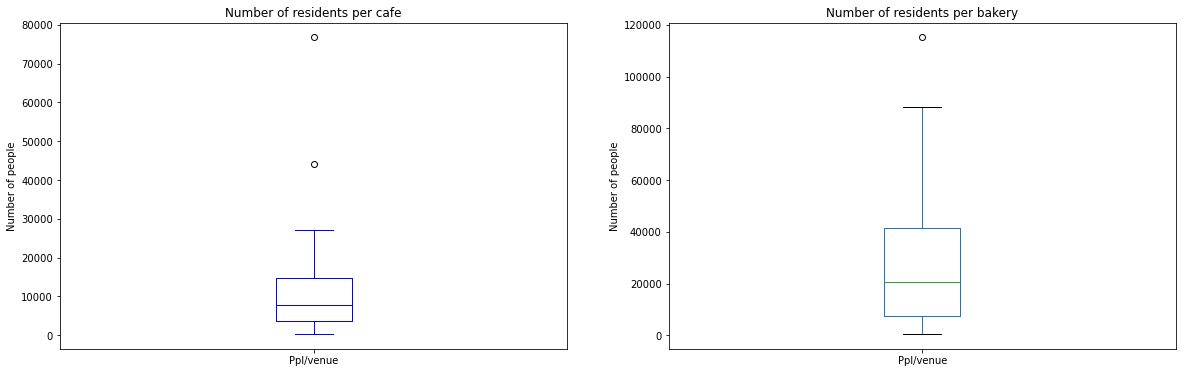

In [31]:
fig = plt.figure()

ax0 = fig.add_subplot(1, 2, 1) 
ax1 = fig.add_subplot(1, 2, 2) 

drinks_density['Ppl/venue'].plot(kind='box', color='blue', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Number of residents per cafe')
#ax0.set_xlabel('Number of Immigrants')
ax0.set_ylabel('Number of people')

# Subplot 2
snacks_density['Ppl/venue'].plot(kind='box', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Number of residents per bakery')
ax1.set_ylabel('Number of people')
#ax1.set_xlabel('Bakery')

plt.show()

Neighborhoods above the **Interquartile Range** are selected.

In [32]:
drink_place = drinks_density[drinks_density['Ppl/venue']>15000]
drink_place.reset_index(drop=True, inplace=True)
drink_place

Neighborhood  Count  Population  Ppl/venue
0         DALA      7      190006    27144.0
1       HLAING      4      176210    44052.0
2    SANCHAUNG      7      109502    15643.0
3       TARMWE     10      181713    18171.0
4  THINGANGYUN      3      230269    76756.0

In [33]:
snack_place = snacks_density[snacks_density['Ppl/venue']>40000]
snack_place.reset_index(drop=True, inplace=True)
snack_place

Neighborhood  Count  Population  Ppl/venue
0               BAHAN      2      106328    53164.0
1              HLAING      2      176210    88105.0
2            KAMARYUT      2       92959    46480.0
3  MINGALARTAUNGNYUNT      3      145638    48546.0
4              YANKIN      2      230269   115134.0

These 9 neighborhoods are chosen for the final study.

In [34]:
drink_ts = drink_place['Neighborhood'].tolist()
snack_ts = snack_place['Neighborhood'].tolist()

ts = list(set(drink_ts + snack_ts))
print(ts)

['TARMWE', 'KAMARYUT', 'HLAING', 'THINGANGYUN', 'MINGALARTAUNGNYUNT', 'DALA', 'BAHAN', 'YANKIN', 'SANCHAUNG']


In [35]:
ds_venue = ygn_venues[ygn_venues['Neighborhood'].isin(ts)]
ds_venue.reset_index(drop=True, inplace=True)

ds_venue.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  MINGALARTAUNGNYUNT              16.783333               96.166667   
1  MINGALARTAUNGNYUNT              16.783333               96.166667   
2  MINGALARTAUNGNYUNT              16.783333               96.166667   
3  MINGALARTAUNGNYUNT              16.783333               96.166667   
4  MINGALARTAUNGNYUNT              16.783333               96.166667   

                     Venue  Venue Latitude  Venue Longitude Venue Category  
0        Rangoon Tea House       16.772273        96.161735       Tea Room  
1     Little Yangon Hostel       16.772335        96.163245         Hostel  
2    The Loft Hotel Yangon       16.782611        96.157219          Hotel  
3                  G Hotel       16.782719        96.158897          Hotel  
4  Park Royal Hotel Yangon       16.783431        96.158465          Hotel

In [36]:
ds_venue.shape[0]

237

Colors are chosen for four of our interesed venue categories.

In [37]:
color_dict = {}

for i in drinks:
    color_dict[i] = 'red'
for i in snacks:
    color_dict[i] = 'yellow'
for i in shelter:
    color_dict[i] = 'green'
for i in shopping:
    color_dict[i] = 'blue'

Another custom data frame of some landmarks is also used.

In [38]:
df_landmark = pd.read_csv('ygn_landmark.csv')
df_landmark.head()

Township                    Landmark   Latitude  Longitude
0     BAHAN     Bogyoke Aung San Museum  16.803839  96.163389
1     BAHAN  Chaukhtatgyi Buddha Temple  16.811623  96.163764
2     BAHAN    Ngahtatgyi Buddha Temple  16.808389  96.162613
3     BAHAN               Fushan Temple  16.825203  96.154344
4  KAMARYUT        University of Yangon  16.833402  96.136164

The venues and some landmarks are visualized together with popuation density.

In [39]:
df_shopping = ds_venue[ds_venue['Venue Category'].isin(shopping)]
df_shelter = ds_venue[ds_venue['Venue Category'].isin(shelter)]
df_drinks = ds_venue[ds_venue['Venue Category'].isin(drinks)]
df_snacks = ds_venue[ds_venue['Venue Category'].isin(snacks)]

In [40]:
for lat, lng, venue, category in zip(ds_venue['Venue Latitude'], ds_venue['Venue Longitude'], ds_venue['Venue'], ds_venue['Venue Category']):    
    folium.features.CircleMarker([lat,lng],
                                 radius = 3,
                                 color = color_dict[category],
                                 fill = True,
                                 fill_color = 'white',
                                 fill_opacity = 0.5).add_to(ygn_map)

for lat, lng, landmark in zip(df_landmark['Latitude'], df_landmark['Longitude'], df_landmark['Landmark']):
    folium.Marker([lat,lng]).add_to(ygn_map)
    
ygn_map

Stakeholders can analyze the density of hotels, cafe(s), bakeries and shopping centers in each neighborhood along side populaiton density by using this kind of map. 

(Labels were not added due to chrome error)

Stakeholders may also be able to compare clusters using the map below:

In [41]:
for lat, lng, venue, category in zip(ds_venue['Venue Latitude'], ds_venue['Venue Longitude'], ds_venue['Venue'], ds_venue['Venue Category']):    
    folium.features.CircleMarker([lat,lng],
                                 radius = 3,
                                 color = color_dict[category],
                                 fill = True,
                                 fill_color = 'white',
                                 fill_opacity = 0.5).add_to(ygn_cluster_map)

ygn_cluster_map

Since **Hlaing Township** is included in both data frames of drinks and snacks, it will be displayed specifically.

In [42]:
ygn_ts = df_ygn_ts.set_index('Township')

Hlaing_venue = ygn_venues[ygn_venues['Neighborhood'] == 'HLAING']
Hlaing_venue.reset_index(drop=True, inplace=True)
Hlaing_venue.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       HLAING              16.858333               96.133333   
1       HLAING              16.858333               96.133333   
2       HLAING              16.858333               96.133333   
3       HLAING              16.858333               96.133333   
4       HLAING              16.858333               96.133333   

                      Venue  Venue Latitude  Venue Longitude Venue Category  
0   Lotte Hotel And Resorts       16.844334        96.137428          Hotel  
1  Marketplace by City Mart       16.846482        96.136595  Shopping Mall  
2               LUCKY SEVEN       16.870703        96.139849           Café  
3                White Swan       16.848155        96.151498         Bakery  
4                Junction 8       16.866938        96.141512  Shopping Mall

In [43]:
Hlaing_latitude = ygn_ts.loc['HLAING','Latitude']
Hlaing_longitude = ygn_ts.loc['HLAING','Longitude']

In [44]:
Hlaing_map = folium.Map(location=[Hlaing_latitude, Hlaing_longitude], zoom_start=13)

for lat, lng, venue, category in zip(Hlaing_venue['Venue Latitude'], Hlaing_venue['Venue Longitude'], Hlaing_venue['Venue'], Hlaing_venue['Venue Category']):
    label = str(venue)
    folium.features.CircleMarker([lat,lng],
                                 radius = 4,
                                 popup = label,
                                 color = color_dict[category],
                                 fill = True,
                                 fill_color = 'white',
                                 fill_opacity = 0.5).add_to(Hlaing_map)

for lat, lng, landmark in zip(df_landmark['Latitude'], df_landmark['Longitude'], df_landmark['Landmark']):
    folium.Marker([lat,lng]).add_to(Hlaing_map)
    
Hlaing_map

We can see some areas where hotel and shopping centers are densed but cafe(s) and bakeries(s) are less densed. 

These will be the suitable location.

(By checking Google Maps, we can find out that many veneus are missing. A better result should be obtained by using a better location data)